In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np

import osu.dataset as dataset


In [ ]:
# reload from saved

xs = np.load(f'.datasets/xs_642_08-13_01-26-33.npy')
ys = np.load(f'.datasets/ys_642_08-13_01-26-33.npy')

# xs = np.load(f'.datasets/xs_142_07-21_21-50-55.npy')
# ys = np.load(f'.datasets/ys_142_07-21_21-50-55.npy')

In [ ]:
xs.shape

In [ ]:
import torch

BATCH_SIZE = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

In [ ]:
# from models.rnn import OsuReplayRNN
# 
# rnn = OsuReplayRNN(batch_size=BATCH_SIZE, noise_std=0.045)
# 
# # vae = OsuReplayVAE.load(".trained/vae_353rcl_9ft.pt")
# 
# rnn.load_data(xs, ys)

In [29]:
from models.vae import OsuReplayVAE
from models.annealer import Annealer

annealer = Annealer(
    total_steps=10,
    range=(0, 0.3),
    cyclical=True,
    stay_max_steps=5
)

# vae = OsuReplayVAE(batch_size=BATCH_SIZE, annealer=annealer, noise_std=0.045)

# vae = OsuReplayVAE.load(".trained/vae_353rcl_9ft.pt")
vae = OsuReplayVAE.load(".trained/replayvae_most_recent.pt", annealer=annealer, noise_std=0.03)

vae.load_data(xs, ys)

ReplayVAE initialized on cuda
decoder parameters: 459122
encoder parameters: 650016
Total parameters: 1109138
VAE loaded from .trained/replayvae_most_recent.pt
Data loaded: 1757 training samples, 440 test samples (position only)


In [ ]:
from models.keys import OsuKeyModel

keys = OsuKeyModel(batch_size=BATCH_SIZE)
keys.load_data(xs, ys)

Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Epoch 1/3, Total_Loss: 430.8811, Recon_Loss: 430.8811, Kl_Loss: 11.8950


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Epoch 2/3, Total_Loss: 357.8525, Recon_Loss: 357.2525, Kl_Loss: 20.0010


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Epoch 3/3, Total_Loss: 354.2142, Recon_Loss: 352.7367, Kl_Loss: 24.6257
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-29-22.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 351.0665, Recon_Loss: 349.0890, Kl_Loss: 21.9719


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Epoch 2/3, Total_Loss: 354.3846, Recon_Loss: 352.1999, Kl_Loss: 18.2059


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 3/3, Total_Loss: 350.6733, Recon_Loss: 348.3069, Kl_Loss: 15.7757
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-30-03.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 1/3, Total_Loss: 352.4994, Recon_Loss: 350.0838, Kl_Loss: 13.4196


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 2/3, Total_Loss: 355.1849, Recon_Loss: 352.4817, Kl_Loss: 12.8724


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 3/3, Total_Loss: 366.8631, Recon_Loss: 363.9187, Kl_Loss: 12.2684
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-30-44.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 1/3, Total_Loss: 375.1800, Recon_Loss: 371.6827, Kl_Loss: 12.9531


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 365.9776, Recon_Loss: 362.6620, Kl_Loss: 11.0518


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Epoch 3/3, Total_Loss: 367.2786, Recon_Loss: 364.2730, Kl_Loss: 10.0187
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-31-25.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 1/3, Total_Loss: 349.8829, Recon_Loss: 346.8711, Kl_Loss: 10.0395


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 2/3, Total_Loss: 349.4534, Recon_Loss: 346.3901, Kl_Loss: 10.2110


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 354.8316, Recon_Loss: 351.7298, Kl_Loss: 10.3391
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-32-06.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 352.4021, Recon_Loss: 352.4021, Kl_Loss: 10.5152


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 348.4109, Recon_Loss: 348.0139, Kl_Loss: 13.2322


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 344.9327, Recon_Loss: 343.9844, Kl_Loss: 15.8055
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-32-47.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 344.9626, Recon_Loss: 343.4528, Kl_Loss: 16.7754


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 355.9662, Recon_Loss: 354.0011, Kl_Loss: 16.3754


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 358.7719, Recon_Loss: 356.3926, Kl_Loss: 15.8618
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-33-27.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 380.1152, Recon_Loss: 377.4613, Kl_Loss: 14.7439


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 393.9867, Recon_Loss: 390.9729, Kl_Loss: 14.3516


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 375.0411, Recon_Loss: 371.8769, Kl_Loss: 13.1842
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-34-08.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 367.7409, Recon_Loss: 364.4910, Kl_Loss: 12.0366


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 362.8469, Recon_Loss: 359.5999, Kl_Loss: 10.8232


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 352.5228, Recon_Loss: 349.4608, Kl_Loss: 10.2067
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-34-48.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 353.0650, Recon_Loss: 350.1739, Kl_Loss: 9.6372


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 354.2875, Recon_Loss: 351.3992, Kl_Loss: 9.6279


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 346.0265, Recon_Loss: 343.2325, Kl_Loss: 9.3131
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-35-29.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 346.5887, Recon_Loss: 346.5887, Kl_Loss: 10.0849


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 343.0961, Recon_Loss: 342.7063, Kl_Loss: 12.9958


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 349.1530, Recon_Loss: 348.1986, Kl_Loss: 15.9062
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-36-09.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 1/3, Total_Loss: 349.8592, Recon_Loss: 348.3503, Kl_Loss: 16.7655


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 358.8758, Recon_Loss: 356.9670, Kl_Loss: 15.9073


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 362.5808, Recon_Loss: 360.3457, Kl_Loss: 14.9001
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-36-50.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 355.7391, Recon_Loss: 353.1264, Kl_Loss: 14.5148


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 358.7892, Recon_Loss: 356.0030, Kl_Loss: 13.2676


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 352.0504, Recon_Loss: 349.1089, Kl_Loss: 12.2562
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-37-31.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 343.7815, Recon_Loss: 340.7451, Kl_Loss: 11.2460


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 354.9603, Recon_Loss: 351.7486, Kl_Loss: 10.7057


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 357.4767, Recon_Loss: 354.4664, Kl_Loss: 10.0342
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-38-11.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 372.3276, Recon_Loss: 369.3474, Kl_Loss: 9.9339


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 368.2648, Recon_Loss: 365.2655, Kl_Loss: 9.9977


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 3/3, Total_Loss: 356.4872, Recon_Loss: 353.6292, Kl_Loss: 9.5264
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-38-52.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 353.2584, Recon_Loss: 353.2584, Kl_Loss: 10.4792


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 356.9617, Recon_Loss: 356.5154, Kl_Loss: 14.8753


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 355.5526, Recon_Loss: 354.4300, Kl_Loss: 18.7106
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-39-32.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 1/3, Total_Loss: 363.8803, Recon_Loss: 362.1783, Kl_Loss: 18.9118


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 376.6126, Recon_Loss: 374.4151, Kl_Loss: 18.3120


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 388.3261, Recon_Loss: 385.6253, Kl_Loss: 18.0058
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-40-13.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 375.2372, Recon_Loss: 372.4345, Kl_Loss: 15.5703


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 374.4938, Recon_Loss: 371.3295, Kl_Loss: 15.0679


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 368.8738, Recon_Loss: 365.5337, Kl_Loss: 13.9175
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-40-54.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 1/3, Total_Loss: 367.6457, Recon_Loss: 364.2381, Kl_Loss: 12.6206


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 355.6648, Recon_Loss: 352.1085, Kl_Loss: 11.8542


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 357.1913, Recon_Loss: 353.9878, Kl_Loss: 10.6783
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-41-34.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 355.2715, Recon_Loss: 352.2900, Kl_Loss: 9.9384


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 358.0910, Recon_Loss: 355.1429, Kl_Loss: 9.8269


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 352.8250, Recon_Loss: 349.8788, Kl_Loss: 9.8209
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-42-15.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 344.5349, Recon_Loss: 344.5349, Kl_Loss: 11.0359


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 344.2048, Recon_Loss: 343.7496, Kl_Loss: 15.1761


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 338.9086, Recon_Loss: 337.8520, Kl_Loss: 17.6109
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-42-55.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 341.4150, Recon_Loss: 339.8001, Kl_Loss: 17.9438


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 343.6858, Recon_Loss: 341.6911, Kl_Loss: 16.6225


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 354.0353, Recon_Loss: 351.9488, Kl_Loss: 13.9101
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-43-36.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 352.1672, Recon_Loss: 349.8648, Kl_Loss: 12.7913


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 349.8921, Recon_Loss: 347.1261, Kl_Loss: 13.1715


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 354.1762, Recon_Loss: 351.2921, Kl_Loss: 12.0171
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-44-16.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 349.3112, Recon_Loss: 346.3288, Kl_Loss: 11.0461


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 348.9774, Recon_Loss: 346.0103, Kl_Loss: 9.8903


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 347.0436, Recon_Loss: 344.1874, Kl_Loss: 9.5209
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-44-57.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 344.0845, Recon_Loss: 341.3217, Kl_Loss: 9.2093


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 356.1606, Recon_Loss: 353.4752, Kl_Loss: 8.9513


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 356.8334, Recon_Loss: 353.9874, Kl_Loss: 9.4865
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-45-37.pt


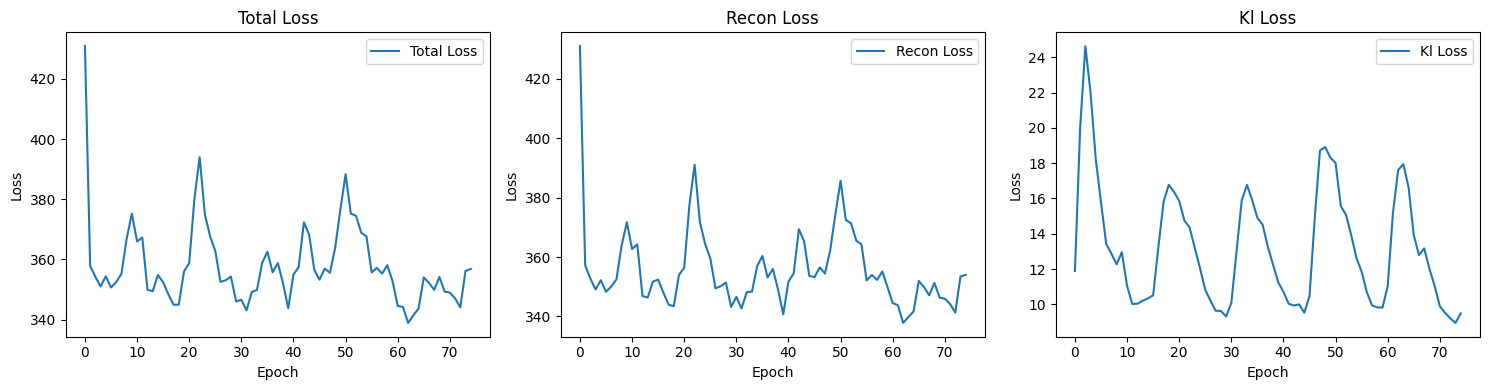

In [30]:
model = vae

EPOCHS = 3

for i in range(25):
    model.train(EPOCHS)
    model.save()
    
model.plot_losses()

Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 346.5733, Recon_Loss: 346.5733, Kl_Loss: 10.1041


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 339.6012, Recon_Loss: 339.2210, Kl_Loss: 12.6734


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 335.8526, Recon_Loss: 334.9592, Kl_Loss: 14.8888
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-46-18.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 347.5412, Recon_Loss: 346.1222, Kl_Loss: 15.7666


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 351.8801, Recon_Loss: 349.9666, Kl_Loss: 15.9456


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 360.3005, Recon_Loss: 358.0299, Kl_Loss: 15.1369
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-46-59.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 347.0189, Recon_Loss: 344.4623, Kl_Loss: 14.2030


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 350.6769, Recon_Loss: 347.9172, Kl_Loss: 13.1414


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 356.1178, Recon_Loss: 353.3036, Kl_Loss: 11.7260
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-47-39.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 355.6584, Recon_Loss: 352.5334, Kl_Loss: 11.5741


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 349.6112, Recon_Loss: 346.5107, Kl_Loss: 10.3352


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 341.2098, Recon_Loss: 338.4208, Kl_Loss: 9.2964
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-48-20.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 347.3687, Recon_Loss: 344.7181, Kl_Loss: 8.8351


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 350.8315, Recon_Loss: 348.1394, Kl_Loss: 8.9737


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 356.4055, Recon_Loss: 353.4571, Kl_Loss: 9.8281
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-49-00.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 354.0173, Recon_Loss: 354.0173, Kl_Loss: 14.2054


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 357.2716, Recon_Loss: 356.7566, Kl_Loss: 17.1676


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 355.2144, Recon_Loss: 353.9893, Kl_Loss: 20.4185
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-49-41.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 342.4017, Recon_Loss: 340.5659, Kl_Loss: 20.3977


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 349.3102, Recon_Loss: 347.0132, Kl_Loss: 19.1417


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 354.2652, Recon_Loss: 351.7462, Kl_Loss: 16.7936
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-50-21.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 351.2448, Recon_Loss: 348.5483, Kl_Loss: 14.9804


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 345.4863, Recon_Loss: 342.7146, Kl_Loss: 13.1987


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 339.6473, Recon_Loss: 336.8565, Kl_Loss: 11.6283
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-51-02.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 341.8958, Recon_Loss: 338.9705, Kl_Loss: 10.8345


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 341.9790, Recon_Loss: 339.0672, Kl_Loss: 9.7063


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 345.1354, Recon_Loss: 342.4065, Kl_Loss: 9.0966
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-51-42.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 343.2674, Recon_Loss: 340.4866, Kl_Loss: 9.2692


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 339.8781, Recon_Loss: 337.2193, Kl_Loss: 8.8626


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 340.3110, Recon_Loss: 337.6824, Kl_Loss: 8.7620
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-52-23.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 338.5761, Recon_Loss: 338.5761, Kl_Loss: 10.5226


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 361.9756, Recon_Loss: 361.5617, Kl_Loss: 13.7963


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 358.6848, Recon_Loss: 357.6086, Kl_Loss: 17.9379
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-53-03.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 362.8121, Recon_Loss: 361.1561, Kl_Loss: 18.3992


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 356.8198, Recon_Loss: 354.7246, Kl_Loss: 17.4601


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 3/3, Total_Loss: 352.0988, Recon_Loss: 349.6718, Kl_Loss: 16.1801
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-53-44.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 351.8131, Recon_Loss: 349.1805, Kl_Loss: 14.6258


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 339.7125, Recon_Loss: 336.9786, Kl_Loss: 13.0187


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 339.5967, Recon_Loss: 336.7753, Kl_Loss: 11.7560
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-54-24.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 355.8368, Recon_Loss: 352.9109, Kl_Loss: 10.8364


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 355.4959, Recon_Loss: 352.3569, Kl_Loss: 10.4636


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 349.3866, Recon_Loss: 346.4854, Kl_Loss: 9.6707
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-55-05.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 349.6186, Recon_Loss: 346.7004, Kl_Loss: 9.7272


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 339.1461, Recon_Loss: 336.3677, Kl_Loss: 9.2612


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 341.1593, Recon_Loss: 338.3945, Kl_Loss: 9.2158
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-55-45.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 347.0009, Recon_Loss: 347.0009, Kl_Loss: 10.5827


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 349.6605, Recon_Loss: 349.1733, Kl_Loss: 16.2395


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 346.6852, Recon_Loss: 345.4494, Kl_Loss: 20.5963
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-56-26.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 341.1678, Recon_Loss: 339.3088, Kl_Loss: 20.6560


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 342.2838, Recon_Loss: 340.1331, Kl_Loss: 17.9221


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 337.1476, Recon_Loss: 334.7785, Kl_Loss: 15.7944
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-57-06.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 344.6572, Recon_Loss: 342.1963, Kl_Loss: 13.6719


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 346.7672, Recon_Loss: 344.1035, Kl_Loss: 12.6843


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 346.1604, Recon_Loss: 343.4093, Kl_Loss: 11.4630
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-57-47.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 349.4380, Recon_Loss: 346.5997, Kl_Loss: 10.5122


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 346.1715, Recon_Loss: 343.1543, Kl_Loss: 10.0576


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 351.8251, Recon_Loss: 348.9799, Kl_Loss: 9.4843
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-58-27.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 340.1523, Recon_Loss: 337.3079, Kl_Loss: 9.4812


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 340.3930, Recon_Loss: 337.5435, Kl_Loss: 9.4981


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 340.7867, Recon_Loss: 338.0800, Kl_Loss: 9.0224
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-59-08.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 354.6873, Recon_Loss: 354.6873, Kl_Loss: 10.4629


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 350.4335, Recon_Loss: 349.9801, Kl_Loss: 15.1129


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 350.0712, Recon_Loss: 348.9645, Kl_Loss: 18.4459
ReplayVAE model saved to .trained/replayvae_2025-08-13_12-59-48.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 355.6709, Recon_Loss: 353.9048, Kl_Loss: 19.6238


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 341.4699, Recon_Loss: 339.3048, Kl_Loss: 18.0422


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 335.6186, Recon_Loss: 333.2238, Kl_Loss: 15.9654
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-00-29.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 334.8566, Recon_Loss: 332.3216, Kl_Loss: 14.0833


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 334.7128, Recon_Loss: 332.1059, Kl_Loss: 12.4142


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 336.9691, Recon_Loss: 334.2849, Kl_Loss: 11.1842
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-01-09.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 1/3, Total_Loss: 340.9934, Recon_Loss: 338.1150, Kl_Loss: 10.6610


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 341.5485, Recon_Loss: 338.5835, Kl_Loss: 9.8835


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 339.8266, Recon_Loss: 337.0329, Kl_Loss: 9.3126
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-01-50.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 346.0601, Recon_Loss: 343.3294, Kl_Loss: 9.1024


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 343.9106, Recon_Loss: 341.1105, Kl_Loss: 9.3336


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 354.8568, Recon_Loss: 352.0596, Kl_Loss: 9.3239
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-02-30.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 359.7370, Recon_Loss: 359.7370, Kl_Loss: 10.4795


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 380.9611, Recon_Loss: 380.4744, Kl_Loss: 16.2223


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 383.6301, Recon_Loss: 382.3667, Kl_Loss: 21.0572
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-03-11.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 380.4402, Recon_Loss: 378.6546, Kl_Loss: 19.8396


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 372.7553, Recon_Loss: 370.3455, Kl_Loss: 20.0817


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 371.6151, Recon_Loss: 368.6844, Kl_Loss: 19.5381
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-03-51.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 357.2994, Recon_Loss: 354.1794, Kl_Loss: 17.3334


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 363.7424, Recon_Loss: 359.9539, Kl_Loss: 18.0405


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 353.1040, Recon_Loss: 349.3706, Kl_Loss: 15.5558
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-04-32.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 348.9897, Recon_Loss: 345.4367, Kl_Loss: 13.1594


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 346.4162, Recon_Loss: 342.8103, Kl_Loss: 12.0197


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 340.7282, Recon_Loss: 337.2945, Kl_Loss: 11.4459
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-05-12.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 340.5166, Recon_Loss: 337.3067, Kl_Loss: 10.6997


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 332.0917, Recon_Loss: 329.1597, Kl_Loss: 9.7733


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 334.6946, Recon_Loss: 331.8785, Kl_Loss: 9.3870
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-05-53.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 339.5525, Recon_Loss: 339.5525, Kl_Loss: 9.9661


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 340.8747, Recon_Loss: 340.4520, Kl_Loss: 14.0913


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 343.0436, Recon_Loss: 341.9308, Kl_Loss: 18.5456
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-06-33.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 344.3245, Recon_Loss: 342.5274, Kl_Loss: 19.9674


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 336.2365, Recon_Loss: 334.0952, Kl_Loss: 17.8444


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 331.1421, Recon_Loss: 328.7750, Kl_Loss: 15.7809
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-07-14.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 339.7515, Recon_Loss: 337.2546, Kl_Loss: 13.8717


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 345.2588, Recon_Loss: 342.5992, Kl_Loss: 12.6651


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 344.1480, Recon_Loss: 341.2329, Kl_Loss: 12.1463
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-07-54.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 357.4920, Recon_Loss: 354.2461, Kl_Loss: 12.0219


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 379.6067, Recon_Loss: 376.2016, Kl_Loss: 11.3501


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 360.8556, Recon_Loss: 357.7003, Kl_Loss: 10.5177
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-08-35.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 356.6272, Recon_Loss: 353.6643, Kl_Loss: 9.8762


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 350.8743, Recon_Loss: 347.8118, Kl_Loss: 10.2083


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 3/3, Total_Loss: 349.2822, Recon_Loss: 346.1863, Kl_Loss: 10.3198
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-09-15.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 338.5074, Recon_Loss: 338.5074, Kl_Loss: 11.0278


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 338.4692, Recon_Loss: 338.0067, Kl_Loss: 15.4146


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 333.8919, Recon_Loss: 332.7812, Kl_Loss: 18.5114
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-09-56.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 337.3240, Recon_Loss: 335.5924, Kl_Loss: 19.2403


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 340.5614, Recon_Loss: 338.3729, Kl_Loss: 18.2377


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 3/3, Total_Loss: 338.2194, Recon_Loss: 335.7971, Kl_Loss: 16.1489
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-10-37.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Epoch 1/3, Total_Loss: 332.7812, Recon_Loss: 330.0892, Kl_Loss: 14.9556


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 2/3, Total_Loss: 340.4981, Recon_Loss: 337.7269, Kl_Loss: 13.1963


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 341.5769, Recon_Loss: 338.7488, Kl_Loss: 11.7840
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-11-18.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 337.7011, Recon_Loss: 334.5756, Kl_Loss: 11.5757


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 334.6964, Recon_Loss: 331.5702, Kl_Loss: 10.4205


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 331.2115, Recon_Loss: 328.3662, Kl_Loss: 9.4841
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-11-58.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 336.8584, Recon_Loss: 334.0951, Kl_Loss: 9.2110


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 339.8629, Recon_Loss: 337.2230, Kl_Loss: 8.7995


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 343.2859, Recon_Loss: 340.5037, Kl_Loss: 9.2741
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-12-39.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 336.0847, Recon_Loss: 336.0847, Kl_Loss: 10.4894


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 348.4099, Recon_Loss: 347.9730, Kl_Loss: 14.5623


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 342.8114, Recon_Loss: 341.7799, Kl_Loss: 17.1914
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-13-19.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 343.6652, Recon_Loss: 342.0580, Kl_Loss: 17.8580


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 340.0435, Recon_Loss: 337.9024, Kl_Loss: 17.8427


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 341.0152, Recon_Loss: 338.5454, Kl_Loss: 16.4649
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-14-00.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 340.8969, Recon_Loss: 338.2376, Kl_Loss: 14.7741


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 340.7541, Recon_Loss: 338.0125, Kl_Loss: 13.0552


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 336.6265, Recon_Loss: 333.7161, Kl_Loss: 12.1265
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-14-40.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 345.8041, Recon_Loss: 342.7649, Kl_Loss: 11.2563


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 347.9144, Recon_Loss: 344.6099, Kl_Loss: 11.0150


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 347.5539, Recon_Loss: 344.3703, Kl_Loss: 10.6119
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-15-21.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 369.0881, Recon_Loss: 365.7817, Kl_Loss: 11.0213


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 366.1358, Recon_Loss: 362.8167, Kl_Loss: 11.0635


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 367.5810, Recon_Loss: 364.2511, Kl_Loss: 11.0998
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-16-01.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 349.3427, Recon_Loss: 349.3427, Kl_Loss: 12.4653


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 336.8916, Recon_Loss: 336.3859, Kl_Loss: 16.8572


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 332.8824, Recon_Loss: 331.6807, Kl_Loss: 20.0271
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-16-42.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 336.1358, Recon_Loss: 334.2892, Kl_Loss: 20.5187


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 338.9579, Recon_Loss: 336.7166, Kl_Loss: 18.6774


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 331.2399, Recon_Loss: 328.6218, Kl_Loss: 17.4541
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-17-22.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 332.1763, Recon_Loss: 329.3116, Kl_Loss: 15.9150


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 337.9996, Recon_Loss: 335.0630, Kl_Loss: 13.9836


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 332.7572, Recon_Loss: 329.6792, Kl_Loss: 12.8250
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-18-03.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 333.1465, Recon_Loss: 329.9179, Kl_Loss: 11.9578


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 338.9817, Recon_Loss: 335.8970, Kl_Loss: 10.2824


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 340.5957, Recon_Loss: 337.5346, Kl_Loss: 10.2037
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-18-43.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 362.1008, Recon_Loss: 359.2829, Kl_Loss: 9.3930


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 2/3, Total_Loss: 342.9713, Recon_Loss: 340.0719, Kl_Loss: 9.6648


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 3/3, Total_Loss: 336.4586, Recon_Loss: 333.5594, Kl_Loss: 9.6641
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-19-24.pt


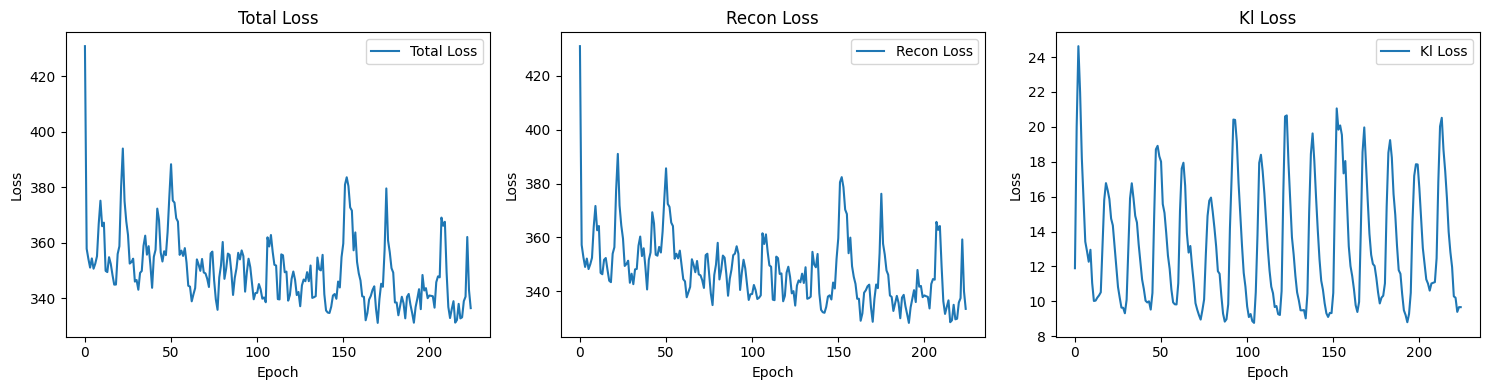

In [31]:
for i in range(50):
    model.train(EPOCHS)
    model.save()
    
model.plot_losses()

In [32]:
for i in range(150):
    model.train(EPOCHS)
    model.save()
    
model.plot_losses()

Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 331.0626, Recon_Loss: 331.0626, Kl_Loss: 11.5985


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 332.2780, Recon_Loss: 331.8237, Kl_Loss: 15.1418


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 332.8401, Recon_Loss: 331.8046, Kl_Loss: 17.2578
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-20-05.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 330.8271, Recon_Loss: 329.2699, Kl_Loss: 17.3025


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 2/3, Total_Loss: 343.2438, Recon_Loss: 341.2242, Kl_Loss: 16.8297


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 3/3, Total_Loss: 347.1190, Recon_Loss: 344.7118, Kl_Loss: 16.0480
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-20-46.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 334.9461, Recon_Loss: 332.1106, Kl_Loss: 15.7527


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 2/3, Total_Loss: 339.9828, Recon_Loss: 337.1954, Kl_Loss: 13.2733


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 344.8925, Recon_Loss: 341.9670, Kl_Loss: 12.1895
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-21-27.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 341.7676, Recon_Loss: 338.7193, Kl_Loss: 11.2901


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 343.4140, Recon_Loss: 340.2712, Kl_Loss: 10.4758


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 332.7219, Recon_Loss: 329.6518, Kl_Loss: 10.2335
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-22-07.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 1/3, Total_Loss: 335.0392, Recon_Loss: 332.1448, Kl_Loss: 9.6480


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 335.3190, Recon_Loss: 332.3856, Kl_Loss: 9.7779


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 3/3, Total_Loss: 332.9353, Recon_Loss: 330.0996, Kl_Loss: 9.4524
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-22-47.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 1/3, Total_Loss: 333.8771, Recon_Loss: 333.8771, Kl_Loss: 10.1489


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 327.2212, Recon_Loss: 326.8193, Kl_Loss: 13.3978


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 329.4462, Recon_Loss: 328.4258, Kl_Loss: 17.0066
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-23-27.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 329.8880, Recon_Loss: 328.2766, Kl_Loss: 17.9045


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 328.6467, Recon_Loss: 326.6344, Kl_Loss: 16.7690


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 336.7088, Recon_Loss: 334.4403, Kl_Loss: 15.1234
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-24-08.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 338.1568, Recon_Loss: 335.5807, Kl_Loss: 14.3119


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 330.1766, Recon_Loss: 327.4432, Kl_Loss: 13.0161


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 329.4700, Recon_Loss: 326.6720, Kl_Loss: 11.6580
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-24-48.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 338.2442, Recon_Loss: 335.4204, Kl_Loss: 10.4587


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 337.9261, Recon_Loss: 334.8771, Kl_Loss: 10.1633


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 3/3, Total_Loss: 346.2640, Recon_Loss: 343.2278, Kl_Loss: 10.1207
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-25-28.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 1/3, Total_Loss: 373.3641, Recon_Loss: 370.1305, Kl_Loss: 10.7785


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 2/3, Total_Loss: 377.4942, Recon_Loss: 374.1270, Kl_Loss: 11.2241


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 3/3, Total_Loss: 381.6948, Recon_Loss: 378.1794, Kl_Loss: 11.7179
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-26-09.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 1/3, Total_Loss: 409.7467, Recon_Loss: 409.7467, Kl_Loss: 12.4514


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 381.9164, Recon_Loss: 381.4032, Kl_Loss: 17.1067


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 3/3, Total_Loss: 368.9442, Recon_Loss: 367.7392, Kl_Loss: 20.0836
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-26-49.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 1/3, Total_Loss: 374.1260, Recon_Loss: 372.0624, Kl_Loss: 22.9281


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 358.4885, Recon_Loss: 356.0573, Kl_Loss: 20.2599


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 353.7819, Recon_Loss: 350.9196, Kl_Loss: 19.0824
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-27-29.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 352.9731, Recon_Loss: 349.8955, Kl_Loss: 17.0975


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 349.6123, Recon_Loss: 346.2570, Kl_Loss: 15.9776


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 345.9954, Recon_Loss: 342.6475, Kl_Loss: 13.9497
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-28-09.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 337.1870, Recon_Loss: 333.7427, Kl_Loss: 12.7565


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 2/3, Total_Loss: 337.9417, Recon_Loss: 334.2763, Kl_Loss: 12.2178


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 350.9219, Recon_Loss: 347.4704, Kl_Loss: 11.5050
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-28-50.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 337.7568, Recon_Loss: 334.3827, Kl_Loss: 11.2467


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 2/3, Total_Loss: 329.9944, Recon_Loss: 326.7571, Kl_Loss: 10.7909


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 335.3158, Recon_Loss: 332.1346, Kl_Loss: 10.6041
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-29-31.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 337.2534, Recon_Loss: 337.2534, Kl_Loss: 11.5826


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 331.4550, Recon_Loss: 331.0198, Kl_Loss: 14.5071


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 338.0078, Recon_Loss: 337.0425, Kl_Loss: 16.0887
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-30-11.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 336.5591, Recon_Loss: 335.0262, Kl_Loss: 17.0326


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 332.1450, Recon_Loss: 330.0949, Kl_Loss: 17.0842


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 331.3916, Recon_Loss: 328.9117, Kl_Loss: 16.5325
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-30-51.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 330.8893, Recon_Loss: 328.1165, Kl_Loss: 15.4043


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 337.3175, Recon_Loss: 334.3731, Kl_Loss: 14.0208


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 328.5100, Recon_Loss: 325.4620, Kl_Loss: 12.7001
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-31-31.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 325.7608, Recon_Loss: 322.5876, Kl_Loss: 11.7525


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 2/3, Total_Loss: 336.1169, Recon_Loss: 332.9997, Kl_Loss: 10.3906


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 331.2094, Recon_Loss: 328.1161, Kl_Loss: 10.3110
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-32-12.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 328.4931, Recon_Loss: 325.3671, Kl_Loss: 10.4200


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 326.3186, Recon_Loss: 323.3192, Kl_Loss: 9.9979


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 327.0056, Recon_Loss: 324.1305, Kl_Loss: 9.5836
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-32-52.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 324.6953, Recon_Loss: 324.6953, Kl_Loss: 10.3181


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 328.7428, Recon_Loss: 328.3279, Kl_Loss: 13.8294


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 330.1159, Recon_Loss: 329.1674, Kl_Loss: 15.8076
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-33-32.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 337.6017, Recon_Loss: 336.1241, Kl_Loss: 16.4178


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 2/3, Total_Loss: 329.8640, Recon_Loss: 327.8720, Kl_Loss: 16.6002


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 3/3, Total_Loss: 325.3895, Recon_Loss: 322.9666, Kl_Loss: 16.1525
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-34-14.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 1/3, Total_Loss: 328.8599, Recon_Loss: 326.2148, Kl_Loss: 14.6951


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 326.5110, Recon_Loss: 323.6122, Kl_Loss: 13.8039


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 333.6087, Recon_Loss: 330.6999, Kl_Loss: 12.1201
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-34-54.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 332.0884, Recon_Loss: 329.0994, Kl_Loss: 11.0704


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 335.1062, Recon_Loss: 331.9732, Kl_Loss: 10.4434


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 333.4329, Recon_Loss: 330.4499, Kl_Loss: 9.9435
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-35-35.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 346.2556, Recon_Loss: 343.0392, Kl_Loss: 10.7214


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 2/3, Total_Loss: 343.7128, Recon_Loss: 340.5343, Kl_Loss: 10.5951


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 3/3, Total_Loss: 335.1238, Recon_Loss: 332.0572, Kl_Loss: 10.2218
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-36-15.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 1/3, Total_Loss: 331.7592, Recon_Loss: 331.7592, Kl_Loss: 11.5318


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 339.7958, Recon_Loss: 339.3334, Kl_Loss: 15.4116


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 337.1698, Recon_Loss: 336.1362, Kl_Loss: 17.2277
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-36-56.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 333.3967, Recon_Loss: 331.8077, Kl_Loss: 17.6558


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Epoch 2/3, Total_Loss: 328.5231, Recon_Loss: 326.3960, Kl_Loss: 17.7258


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 332.2138, Recon_Loss: 329.6737, Kl_Loss: 16.9338
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-37-37.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 1/3, Total_Loss: 339.9166, Recon_Loss: 337.1700, Kl_Loss: 15.2588


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 339.0082, Recon_Loss: 336.1676, Kl_Loss: 13.5264


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 333.8345, Recon_Loss: 330.9044, Kl_Loss: 12.2086
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-38-17.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 335.7482, Recon_Loss: 332.5791, Kl_Loss: 11.7373


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 2/3, Total_Loss: 329.9956, Recon_Loss: 326.5587, Kl_Loss: 11.4564


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 334.9685, Recon_Loss: 331.9139, Kl_Loss: 10.1822
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-38-57.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 337.1688, Recon_Loss: 334.1561, Kl_Loss: 10.0420


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 344.3190, Recon_Loss: 341.2728, Kl_Loss: 10.1539


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 333.7400, Recon_Loss: 330.7299, Kl_Loss: 10.0338
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-39-38.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 330.5506, Recon_Loss: 330.5506, Kl_Loss: 10.8061


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 332.5170, Recon_Loss: 332.0810, Kl_Loss: 14.5335


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 329.6934, Recon_Loss: 328.7046, Kl_Loss: 16.4802
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-40-18.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 325.1913, Recon_Loss: 323.6168, Kl_Loss: 17.4944


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 323.4858, Recon_Loss: 321.4265, Kl_Loss: 17.1603


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 318.3003, Recon_Loss: 315.9169, Kl_Loss: 15.8890
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-40-58.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 326.9220, Recon_Loss: 324.3352, Kl_Loss: 14.3713


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 328.3178, Recon_Loss: 325.5937, Kl_Loss: 12.9722


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 331.0649, Recon_Loss: 328.2194, Kl_Loss: 11.8560
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-41-38.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 333.8792, Recon_Loss: 330.9017, Kl_Loss: 11.0277


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 327.3359, Recon_Loss: 324.1896, Kl_Loss: 10.4877


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 3/3, Total_Loss: 332.4827, Recon_Loss: 329.5371, Kl_Loss: 9.8187
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-42-19.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 329.8028, Recon_Loss: 326.9112, Kl_Loss: 9.6384


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 2/3, Total_Loss: 327.4533, Recon_Loss: 324.6519, Kl_Loss: 9.3381


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 331.1269, Recon_Loss: 328.3235, Kl_Loss: 9.3445
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-42-59.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 321.5292, Recon_Loss: 321.5292, Kl_Loss: 10.2965


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 324.2608, Recon_Loss: 323.8465, Kl_Loss: 13.8124


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 325.5141, Recon_Loss: 324.4740, Kl_Loss: 17.3349
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-43-39.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 329.2772, Recon_Loss: 327.7053, Kl_Loss: 17.4664


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 330.2227, Recon_Loss: 328.1726, Kl_Loss: 17.0844


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 326.2222, Recon_Loss: 323.7963, Kl_Loss: 16.1727
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-44-19.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 333.7420, Recon_Loss: 331.1210, Kl_Loss: 14.5611


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 328.6856, Recon_Loss: 325.8759, Kl_Loss: 13.3796


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 339.4977, Recon_Loss: 336.5515, Kl_Loss: 12.2759
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-44-59.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 335.3992, Recon_Loss: 332.3863, Kl_Loss: 11.1591


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 333.1113, Recon_Loss: 329.9642, Kl_Loss: 10.4903


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 323.2894, Recon_Loss: 320.2780, Kl_Loss: 10.0380
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-45-40.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 331.1486, Recon_Loss: 328.3411, Kl_Loss: 9.3582


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 323.6033, Recon_Loss: 320.7622, Kl_Loss: 9.4703


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 328.4687, Recon_Loss: 325.6968, Kl_Loss: 9.2397
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-46-20.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 329.3618, Recon_Loss: 329.3618, Kl_Loss: 10.0390


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 327.2116, Recon_Loss: 326.8573, Kl_Loss: 11.8101


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 317.1571, Recon_Loss: 316.3672, Kl_Loss: 13.1653
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-47-00.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 316.8382, Recon_Loss: 315.5331, Kl_Loss: 14.5015


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 318.1463, Recon_Loss: 316.4226, Kl_Loss: 14.3643


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 324.4504, Recon_Loss: 322.4354, Kl_Loss: 13.4334
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-47-41.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 324.9695, Recon_Loss: 322.7088, Kl_Loss: 12.5594


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 2/3, Total_Loss: 326.3108, Recon_Loss: 323.8298, Kl_Loss: 11.8140


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 3/3, Total_Loss: 333.4442, Recon_Loss: 330.7365, Kl_Loss: 11.2821
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-48-21.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 337.9117, Recon_Loss: 334.8158, Kl_Loss: 11.4662


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 333.1711, Recon_Loss: 329.9690, Kl_Loss: 10.6738


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 344.0583, Recon_Loss: 341.0114, Kl_Loss: 10.1566
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-49-01.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 341.9243, Recon_Loss: 339.0294, Kl_Loss: 9.6496


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 2/3, Total_Loss: 339.2108, Recon_Loss: 336.3287, Kl_Loss: 9.6068


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Epoch 3/3, Total_Loss: 335.7056, Recon_Loss: 332.8626, Kl_Loss: 9.4767
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-49-41.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 324.8154, Recon_Loss: 324.8154, Kl_Loss: 10.6734


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 328.4193, Recon_Loss: 327.9913, Kl_Loss: 14.2648


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 342.9183, Recon_Loss: 341.9410, Kl_Loss: 16.2874
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-50-21.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 343.9405, Recon_Loss: 342.4008, Kl_Loss: 17.1068


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 327.0497, Recon_Loss: 324.9719, Kl_Loss: 17.3149


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 325.1593, Recon_Loss: 322.7791, Kl_Loss: 15.8684
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-51-02.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 326.3259, Recon_Loss: 323.7708, Kl_Loss: 14.1945


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 326.7166, Recon_Loss: 323.8896, Kl_Loss: 13.4619


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 322.0171, Recon_Loss: 319.0659, Kl_Loss: 12.2965
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-51-42.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 322.6806, Recon_Loss: 319.6363, Kl_Loss: 11.2754


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 331.6806, Recon_Loss: 328.6320, Kl_Loss: 10.1622


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 324.6312, Recon_Loss: 321.6618, Kl_Loss: 9.8979
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-52-22.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 322.4070, Recon_Loss: 319.4761, Kl_Loss: 9.7696


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 314.9592, Recon_Loss: 312.1565, Kl_Loss: 9.3425


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 318.9603, Recon_Loss: 316.1643, Kl_Loss: 9.3199
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-53-02.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 321.6487, Recon_Loss: 321.6487, Kl_Loss: 10.1817


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 332.7798, Recon_Loss: 332.3898, Kl_Loss: 12.9981


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 337.1229, Recon_Loss: 336.1631, Kl_Loss: 15.9974
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-53-42.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 339.1397, Recon_Loss: 337.5032, Kl_Loss: 18.1834


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 336.4119, Recon_Loss: 334.1954, Kl_Loss: 18.4707


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 331.2304, Recon_Loss: 328.6697, Kl_Loss: 17.0718
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-54-23.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 325.4600, Recon_Loss: 322.7256, Kl_Loss: 15.1910


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 333.7776, Recon_Loss: 330.9501, Kl_Loss: 13.4644


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 327.3026, Recon_Loss: 324.3132, Kl_Loss: 12.4556
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-55-03.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 334.7646, Recon_Loss: 331.6866, Kl_Loss: 11.4000


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 332.5877, Recon_Loss: 329.3640, Kl_Loss: 10.7456


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 337.4045, Recon_Loss: 334.3136, Kl_Loss: 10.3029
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-55-43.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 373.7256, Recon_Loss: 370.6206, Kl_Loss: 10.3501


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 413.9174, Recon_Loss: 410.5788, Kl_Loss: 11.1287


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 368.3193, Recon_Loss: 364.7127, Kl_Loss: 12.0219
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-56-24.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 348.0676, Recon_Loss: 348.0676, Kl_Loss: 13.5037


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 352.7026, Recon_Loss: 352.1025, Kl_Loss: 20.0021


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 341.8836, Recon_Loss: 340.3374, Kl_Loss: 25.7706
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-57-04.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 329.6530, Recon_Loss: 327.3416, Kl_Loss: 25.6831


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 339.6705, Recon_Loss: 337.0700, Kl_Loss: 21.6706


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 328.2757, Recon_Loss: 325.4656, Kl_Loss: 18.7340
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-57-45.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 343.6646, Recon_Loss: 340.7443, Kl_Loss: 16.2238


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 345.8044, Recon_Loss: 342.7456, Kl_Loss: 14.5657


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 342.8220, Recon_Loss: 339.5969, Kl_Loss: 13.4381
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-58-25.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 330.2689, Recon_Loss: 326.9541, Kl_Loss: 12.2773


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 330.0106, Recon_Loss: 326.5020, Kl_Loss: 11.6951


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 327.4323, Recon_Loss: 324.0833, Kl_Loss: 11.1633
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-59-06.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 324.6522, Recon_Loss: 321.5393, Kl_Loss: 10.3761


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 321.3899, Recon_Loss: 318.3502, Kl_Loss: 10.1324


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 327.8629, Recon_Loss: 324.9510, Kl_Loss: 9.7061
ReplayVAE model saved to .trained/replayvae_2025-08-13_13-59-46.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 327.4730, Recon_Loss: 327.4730, Kl_Loss: 10.7540


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 324.3945, Recon_Loss: 323.9772, Kl_Loss: 13.9095


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 326.9358, Recon_Loss: 325.9189, Kl_Loss: 16.9485
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-00-27.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 331.7414, Recon_Loss: 329.9916, Kl_Loss: 19.4419


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 319.0865, Recon_Loss: 316.9076, Kl_Loss: 18.1569


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 320.8908, Recon_Loss: 318.5529, Kl_Loss: 15.5859
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-01-07.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 320.7973, Recon_Loss: 318.2284, Kl_Loss: 14.2720


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 322.1235, Recon_Loss: 319.3711, Kl_Loss: 13.1068


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 326.5183, Recon_Loss: 323.6482, Kl_Loss: 11.9588
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-01-47.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 325.4981, Recon_Loss: 322.5027, Kl_Loss: 11.0941


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 2/3, Total_Loss: 326.2199, Recon_Loss: 323.0402, Kl_Loss: 10.5990


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 320.4388, Recon_Loss: 317.3282, Kl_Loss: 10.3685
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-02-28.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 323.9029, Recon_Loss: 320.9087, Kl_Loss: 9.9805


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 320.2907, Recon_Loss: 317.3429, Kl_Loss: 9.8261


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 317.4819, Recon_Loss: 314.6670, Kl_Loss: 9.3828
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-03-08.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 1/3, Total_Loss: 313.7820, Recon_Loss: 313.7820, Kl_Loss: 10.3388


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 316.7411, Recon_Loss: 316.3340, Kl_Loss: 13.5726


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 322.2528, Recon_Loss: 321.2985, Kl_Loss: 15.9042
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-03-49.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 327.8004, Recon_Loss: 326.2288, Kl_Loss: 17.4621


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 336.5530, Recon_Loss: 334.5030, Kl_Loss: 17.0837


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 324.1630, Recon_Loss: 321.6938, Kl_Loss: 16.4615
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-04-30.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 323.1507, Recon_Loss: 320.5045, Kl_Loss: 14.7010


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 327.4431, Recon_Loss: 324.5867, Kl_Loss: 13.6018


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 325.9043, Recon_Loss: 322.8737, Kl_Loss: 12.6276
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-05-10.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 330.6059, Recon_Loss: 327.4913, Kl_Loss: 11.5355


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 349.5420, Recon_Loss: 346.2445, Kl_Loss: 10.9917


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 343.8324, Recon_Loss: 340.6844, Kl_Loss: 10.4934
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-05-51.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 1/3, Total_Loss: 345.9428, Recon_Loss: 342.5986, Kl_Loss: 11.1473


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 343.4782, Recon_Loss: 340.1401, Kl_Loss: 11.1271


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 343.3789, Recon_Loss: 340.1128, Kl_Loss: 10.8871
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-06-31.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 330.8064, Recon_Loss: 330.8064, Kl_Loss: 12.0022


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 327.7416, Recon_Loss: 327.2663, Kl_Loss: 15.8416


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 327.5048, Recon_Loss: 326.3908, Kl_Loss: 18.5679
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-07-11.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 336.2016, Recon_Loss: 334.4379, Kl_Loss: 19.5960


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 340.0686, Recon_Loss: 337.7736, Kl_Loss: 19.1249


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 349.1469, Recon_Loss: 346.5238, Kl_Loss: 17.4869
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-07-52.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 346.4567, Recon_Loss: 343.4579, Kl_Loss: 16.6597


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 329.7375, Recon_Loss: 326.3976, Kl_Loss: 15.9041


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 323.8851, Recon_Loss: 320.3477, Kl_Loss: 14.7394
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-08-32.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 322.1388, Recon_Loss: 318.6331, Kl_Loss: 12.9843


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/3, Total_Loss: 324.7061, Recon_Loss: 321.3229, Kl_Loss: 11.2774


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 323.0711, Recon_Loss: 319.9211, Kl_Loss: 10.5000
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-09-13.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 1/3, Total_Loss: 328.1962, Recon_Loss: 325.1320, Kl_Loss: 10.2140


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 331.2970, Recon_Loss: 328.1275, Kl_Loss: 10.5648


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 3/3, Total_Loss: 339.7793, Recon_Loss: 336.5956, Kl_Loss: 10.6126
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-09-53.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 335.5911, Recon_Loss: 335.5911, Kl_Loss: 12.1572


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 333.5346, Recon_Loss: 333.0424, Kl_Loss: 16.4077


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 3/3, Total_Loss: 336.8338, Recon_Loss: 335.6619, Kl_Loss: 19.5310
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-10-33.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 335.8852, Recon_Loss: 334.1074, Kl_Loss: 19.7534


Epoch 2/3 (Beta: 0.12): 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Epoch 2/3, Total_Loss: 325.4873, Recon_Loss: 323.1659, Kl_Loss: 19.3449


Epoch 3/3 (Beta: 0.15): 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Epoch 3/3, Total_Loss: 318.9205, Recon_Loss: 316.2953, Kl_Loss: 17.5010
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-11-14.pt


Epoch 1/3 (Beta: 0.18): 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Epoch 1/3, Total_Loss: 323.7188, Recon_Loss: 320.9582, Kl_Loss: 15.3362


Epoch 2/3 (Beta: 0.21): 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Epoch 2/3, Total_Loss: 323.7377, Recon_Loss: 320.7703, Kl_Loss: 14.1304


Epoch 3/3 (Beta: 0.24): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 3/3, Total_Loss: 324.1757, Recon_Loss: 321.0690, Kl_Loss: 12.9448
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-11-55.pt


Epoch 1/3 (Beta: 0.27): 100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Epoch 1/3, Total_Loss: 319.7700, Recon_Loss: 316.5948, Kl_Loss: 11.7601


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Epoch 2/3, Total_Loss: 320.8118, Recon_Loss: 317.5358, Kl_Loss: 10.9200


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Epoch 3/3, Total_Loss: 320.3886, Recon_Loss: 317.3655, Kl_Loss: 10.0770
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-12-36.pt


Epoch 1/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 1/3, Total_Loss: 328.1456, Recon_Loss: 325.1732, Kl_Loss: 9.9080


Epoch 2/3 (Beta: 0.3): 100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Epoch 2/3, Total_Loss: 323.0050, Recon_Loss: 320.0365, Kl_Loss: 9.8952


Epoch 3/3 (Beta: 0.3): 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Epoch 3/3, Total_Loss: 323.2326, Recon_Loss: 320.3371, Kl_Loss: 9.6519
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-13-15.pt


Epoch 1/3 (Beta: 0.0): 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Epoch 1/3, Total_Loss: 322.6558, Recon_Loss: 322.6558, Kl_Loss: 11.1152


Epoch 2/3 (Beta: 0.03): 100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Epoch 2/3, Total_Loss: 345.3188, Recon_Loss: 344.8699, Kl_Loss: 14.9643


Epoch 3/3 (Beta: 0.06): 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]


Epoch 3/3, Total_Loss: 336.8340, Recon_Loss: 335.7646, Kl_Loss: 17.8247
ReplayVAE model saved to .trained/replayvae_2025-08-13_14-14-03.pt


Epoch 1/3 (Beta: 0.09): 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]


Epoch 1/3, Total_Loss: 335.6956, Recon_Loss: 334.0856, Kl_Loss: 17.8896


Epoch 2/3 (Beta: 0.12):  32%|███▏      | 9/28 [00:05<00:12,  1.54it/s]


KeyboardInterrupt: 

In [ ]:
for i in range(150):
    model.train(EPOCHS)
    model.save()
    
model.plot_losses()

In [ ]:
del vae

In [ ]:
annealer = Annealer(
    total_steps=10,
    range=(0, 0.25),
    cyclical=True,
    stay_max_steps=5
)

vae = OsuReplayVAE(batch_size=BATCH_SIZE, annealer=annealer, noise_std=0.045)

# vae = OsuReplayVAE.load(".trained/vae_353rcl_9ft.pt")
# vae = OsuReplayVAE.load(".trained/vae_most_recent.pt")

vae.load_data(xs, ys)

model = vae

In [ ]:
for i in range(175):
    model.train(EPOCHS)
    model.save()
    
model.plot_losses()

In [ ]:
for i in range(300):
    model.train(EPOCHS)
    model.save()
    
model.plot_losses()

In [ ]:
# test training results
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.dataset as dataset

test_name = 'zuttosummer'
test_mods = Mods.DOUBLE_TIME
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

In [ ]:
replay_data = vae.generate(data)
    
replay_data = np.concatenate(replay_data)
replay_data = np.pad(replay_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
print(f"Generated replay data shape: {replay_data.shape}")


In [ ]:
import osu.preview.preview as preview

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)